### Predicting Heart Rate During a Run using a Random Forest Regressor
- Using a heart rate monitor, there can be periods of time where heart rate values are not recorded due to faulty human movements where the monitor moves/slides, battery issues, and technical malfunctions.
- Data is all mine (all one subject) using a Polar H10 monitor during runs of 2024 and downloaded from Polar Flow.

In [1]:
# Import Libraries
import os
import pandas as pd
import numpy as np
import datetime
import seaborn as sns
import matplotlib.pyplot as plt
from datetime import datetime
from functions import convert_time_to_seconds

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, r2_score, root_mean_squared_error

In [2]:
# Specify the file path
file_path = 'RunningData/David+_Diaz+_2024-01-01_15-35-44.CSV'
# Read the first row separately as it contains aggregated statistics
header = pd.read_csv(file_path, nrows=1)
# Grab the rest of the rows on the data
running = pd.read_csv(file_path, skiprows=[0, 1])

In [3]:
# Path to the folder of data
folder_path = 'RunningData'
number_of_files = 0

# Create an empty list to store all running data
all_running_data = []

# Create an empty list to store all aggregated data
all_headers_data = []
# Iterate through each file in the folder
for filename in os.listdir(folder_path):
    file_path = os.path.join(folder_path, filename)
    
    # Check if the file is a CSV
    if filename.endswith('.CSV'):
        print(f"Processing file: {filename}")
        number_of_files += 1
        
        try:
            # Read the first row separately (aggregated statistics)
            header = pd.read_csv(file_path, nrows=1)
            
            # Read the rest of the data, skipping the first two rows
            running = pd.read_csv(file_path, skiprows=[0, 1])
            
            # Extract Date and Start Time from header
            date_str = header['Date'].values[0]  # Assuming it's in 'Date' column
            start_time_str = header['Start time'].values[0]  # Assuming it's in 'Start time' column

            # Combine the date and start time to form a datetime object
            start_datetime_str = f"{date_str} {start_time_str}"
            start_datetime = datetime.strptime(start_datetime_str, "%d-%m-%Y %H:%M:%S")
            
            # Convert 'Time' column (hh:mm:ss format) to timedeltas
            running['Time'] = pd.to_timedelta(running['Time'])

            # Create a new column 'Real_Time' by adding 'Time' column to the start datetime
            running['Real_Time'] = running['Time'] + start_datetime

            running['Source_File'] = filename

            # Append the Headers to the list
            all_headers_data.append(header)
            
            # Append the processed DataFrame to the list
            all_running_data.append(running)

        except pd.errors.EmptyDataError:
            print(f"Error: {filename} is empty or has invalid format")
        except FileNotFoundError:
            print(f"Error: {filename} not found")
        except Exception as e:
            print(f"An error occurred while processing {filename}: {e}")

print(f"\n Total Amount of Files Processes: {number_of_files}")

Processing file: David+_Diaz+_2024-02-06_14-43-30.CSV
Processing file: David+_Diaz+_2024-06-21_19-35-59.CSV
Processing file: David+_Diaz+_2024-01-09_16-27-42.CSV
Processing file: David+_Diaz+_2024-07-03_17-52-41.CSV
Processing file: David+_Diaz+_2024-07-16_20-02-21.CSV
Processing file: David+_Diaz+_2024-07-24_19-57-39.CSV
Processing file: David+_Diaz+_2024-01-11_15-59-36.CSV
Processing file: David+_Diaz+_2024-01-23_14-30-16.CSV
Processing file: David+_Diaz+_2024-01-27_17-09-41.CSV
Processing file: David+_Diaz+_2024-06-26_20-05-02.CSV
Processing file: David+_Diaz+_2024-01-01_15-35-44.CSV
Processing file: David+_Diaz+_2024-07-27_18-05-44.CSV
Processing file: David+_Diaz+_2024-01-16_14-07-56.CSV
Processing file: David+_Diaz+_2024-02-16_14-21-16.CSV
Processing file: David+_Diaz+_2024-06-03_18-49-07.CSV
Processing file: David+_Diaz+_2024-01-18_10-42-57.CSV
Processing file: David+_Diaz+_2024-06-09_17-36-33.CSV
Processing file: David+_Diaz+_2024-02-03_12-12-54.CSV
Processing file: David+_Diaz

In [4]:
# After processing all files, concatenate all the DataFrames into one
if all_running_data:
    combined_running_df = pd.concat(all_running_data, ignore_index=True)
    
else:
    print("No data to concatenate.")

In [5]:
if all_headers_data:
    combined_headers_df = pd.concat(all_headers_data, ignore_index=True)
    
else:
    print("No data to concatenate.")

In [6]:
# Rename the Columns into Name without whitespaces
combined_running_df.rename(columns={'HR (bpm)': 'HR', 'Speed (mi/h)': 'Speed', 'Pace (min/mi)': 'Original_Pace', 'Distances (ft)': 'distances'}, inplace=True)

In [7]:
# Create new Columns and utilize the function from above to convert into their respective units
combined_running_df['Pace'] = combined_running_df['Original_Pace'].apply(convert_time_to_seconds)

In [8]:
# Convert Real_Time to datetime type
combined_running_df['Real_Time'] = pd.to_datetime(combined_running_df['Real_Time'])

In [9]:
# Create an instance for the label encoder
le = LabelEncoder()
# Fit the encoder on the dataframe column Source_File
combined_running_df['run_id'] = le.fit_transform(combined_running_df['Source_File'])

In [10]:
# Create a column to hold the date of the run
combined_running_df['Date'] = combined_running_df['Real_Time'].dt.date

In [11]:
# Karvonian Method to calculate ranges
age = 25

# Calculate Maximum Heart Rate (MHR)
MHR = 220 - age

# Define heart rate zones based on percentages of MHR
zones = {
    "Zone 1 (Very Light)": (0.50 * MHR, 0.60 * MHR),
    "Zone 2 (Light)": (0.60 * MHR, 0.70 * MHR),
    "Zone 3 (Moderate)": (0.70 * MHR, 0.80 * MHR),
    "Zone 4 (Hard)": (0.80 * MHR, 0.90 * MHR),
    "Zone 5 (Maximum)": (0.90 * MHR, MHR)
}

In [12]:
# Print heart rate zones
for zone, (lower, upper) in zones.items():
    print(f"{zone}: {lower:.1f} - {upper:.1f} bpm")

Zone 1 (Very Light): 97.5 - 117.0 bpm
Zone 2 (Light): 117.0 - 136.5 bpm
Zone 3 (Moderate): 136.5 - 156.0 bpm
Zone 4 (Hard): 156.0 - 175.5 bpm
Zone 5 (Maximum): 175.5 - 195.0 bpm


In [13]:
# function to assign HR categories
def assign_hr_category(hr):
    for zone, (low, high) in zones.items():
        if low <= hr < high:
            return zone
    return "Outside Zones"  # For values outside defined zones

In [14]:
# Assign the Hearrt Rate Category to the data based on HR value
combined_running_df['HR_Category'] = combined_running_df['HR'].apply(assign_hr_category)

In [15]:
# Visualize the concatenated data
combined_running_df.head()

,Sample rate,Time,HR,Speed,Original_Pace,Cadence,Altitude (ft),Stride length (in),distances,Temperatures (F),Power (W),Unnamed: 11,Real_Time,Source_File,Pace,run_id,Date,HR_Category
0,1.0,0 days 00:00:00,116.0,0.0,00:00,NaN,NaN,NaN,0.00,NaN,NaN,NaN,2024-02-06 14:43:30,David+_Diaz+_2024-02-06_14-43-30.CSV,0.000000,9,2024-02-06,Zone 1 (Very Light)
1,NaN,0 days 00:00:01,116.0,3.2,18:36,NaN,NaN,NaN,0.00,NaN,NaN,NaN,2024-02-06 14:43:31,David+_Diaz+_2024-02-06_14-43-30.CSV,18.600000,9,2024-02-06,Zone 1 (Very Light)
2,NaN,0 days 00:00:02,116.0,5.9,10:13,NaN,NaN,NaN,14.85,NaN,NaN,NaN,2024-02-06 14:43:32,David+_Diaz+_2024-02-06_14-43-30.CSV,10.216667,9,2024-02-06,Zone 1 (Very Light)
3,NaN,0 days 00:00:03,116.0,5.9,10:13,NaN,NaN,NaN,27.78,NaN,NaN,NaN,2024-02-06 14:43:33,David+_Diaz+_2024-02-06_14-43-30.CSV,10.216667,9,2024-02-06,Zone 1 (Very Light)
4,NaN,0 days 00:00:04,116.0,7.5,07:57,NaN,NaN,NaN,42.63,NaN,NaN,NaN,2024-02-06 14:43:34,David+_Diaz+_2024-02-06_14-43-30.CSV,7.950000,9,2024-02-06,Zone 1 (Very Light)


In [16]:
# Filter by only certain columns
data = combined_running_df[['run_id','Real_Time', 'HR', 'Pace', 'Speed', 'HR_Category', 'Date']]

In [17]:
# Find Missing Values
data.isna().sum()

run_id             0
Real_Time          0
HR             13632
Pace               0
Speed              0
HR_Category        0
Date               0
dtype: int64

In [18]:
# Create a variable to hold all the null values
null_values = data[data['HR'].isna()]
# Count the number of rows for each date in null_values
total_count_of_rows_by_day = null_values.groupby('Date').size().reset_index(name='Count_of_Rows')

In [19]:
# Find Counts of Nulls by Date
total_count_of_rows_by_day

,Date,Count_of_Rows
0,2024-06-03,1165
1,2024-06-09,892
2,2024-06-21,1594
3,2024-06-26,2056
4,2024-06-30,1018
5,2024-07-03,1010
6,2024-07-16,1075
7,2024-07-20,1610
8,2024-07-24,1612
9,2024-07-27,1600


#### These runs do not have heart rate values because there were due to two reasons: 1. bluetooth issues between the monitor and phone 2. Dead Batteries. (two were correlated as when newer batteries where inserted, there were connectivity issues, some days it would work, while it would not on others)

In [20]:
# Get the list of dates to remove
dates_to_remove = total_count_of_rows_by_day['Date'].unique()

# Remove rows where the date in 'Real_Time' is in dates_to_remove
filtered_data = data[~data['Real_Time'].dt.date.isin(dates_to_remove)]

In [21]:
# Remove Low values
filtered_data = filtered_data[filtered_data['HR'] > 60]

#### To be very clear here, HR values under 60 were due to the monitor stop recording during a run. 2-16-2024 to be exact.

In [22]:
# Describe Statistics
filtered_data.describe()

,run_id,Real_Time,HR,Pace,Speed
count,20877.000000,20877,20877.000000,20877.000000,20877.000000
mean,6.752694,2024-01-29 18:45:43.975523328,159.686018,8.406899,7.278594
min,0.000000,2024-01-01 15:35:44,86.000000,0.000000,0.000000
25%,3.000000,2024-01-16 14:23:54,156.000000,7.633333,6.800000
50%,7.000000,2024-01-29 14:20:28,161.000000,8.200000,7.300000
75%,11.000000,2024-02-13 17:18:31,165.000000,8.833333,7.900000
max,13.000000,2024-02-25 18:25:30,177.000000,48.266667,10.800000
std,4.052019,NaN,8.358841,1.487582,0.970689


In [23]:
# Create Variables for ease of use
real_time = filtered_data['Real_Time']
heart_rate = filtered_data['HR']
pace = filtered_data['Pace']
speed = filtered_data['Speed']

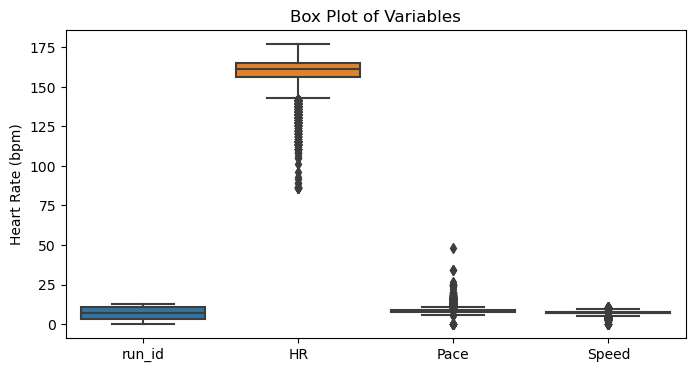

In [24]:
# Create a box plot to understand distribution and detect outliers
plt.figure(figsize=(8, 4))
sns.boxplot(filtered_data)
plt.title('Box Plot of Variables')
plt.ylabel('Heart Rate (bpm)')
plt.show()

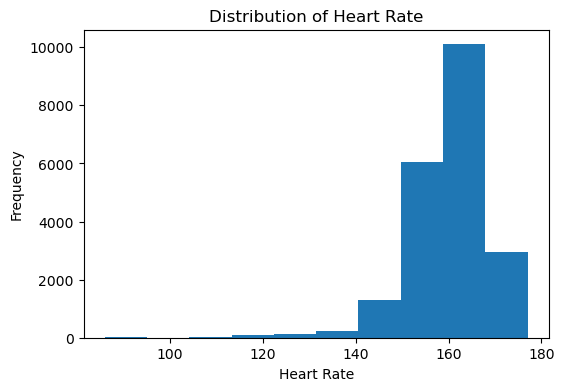

In [25]:
# Visualize Histogram on Heart Rate
plt.figure(figsize=(6,4))
plt.hist(heart_rate)
plt.title('Distribution of Heart Rate')
plt.xlabel('Heart Rate')
plt.ylabel('Frequency')
plt.show()

In [26]:
# Find Dates for Unique Dates
unique_runs = filtered_data['Real_Time'].dt.date.unique()
formatted_dates = [date.strftime("%Y-%m-%d") for date in unique_runs]
formatted_dates

['2024-02-06',
 '2024-01-09',
 '2024-01-11',
 '2024-01-23',
 '2024-01-27',
 '2024-01-01',
 '2024-01-16',
 '2024-02-16',
 '2024-01-18',
 '2024-02-03',
 '2024-02-25',
 '2024-02-13',
 '2024-02-10',
 '2024-01-29']

In [27]:
# Calculate time difference and aggregate HR for all runs
filtered_data['seconds'] = (filtered_data['Real_Time'] - filtered_data.groupby('run_id')['Real_Time'].transform('min')).dt.total_seconds().astype(int)

In [28]:
# Aggregate heart rate data across all runs by seconds
aggregated_data = filtered_data.groupby('seconds').agg(
    mean_hr=('HR', 'mean'),
    min_hr=('HR', 'min'),
    max_hr=('HR', 'max'),
    median_hr=('HR', 'median'),
    std_hr=('HR', 'std'),
    var_hr=('HR', 'var'),
    count_hr=('HR', 'count'),
    range_hr=('HR', lambda x: x.max() - x.min())
).reset_index()

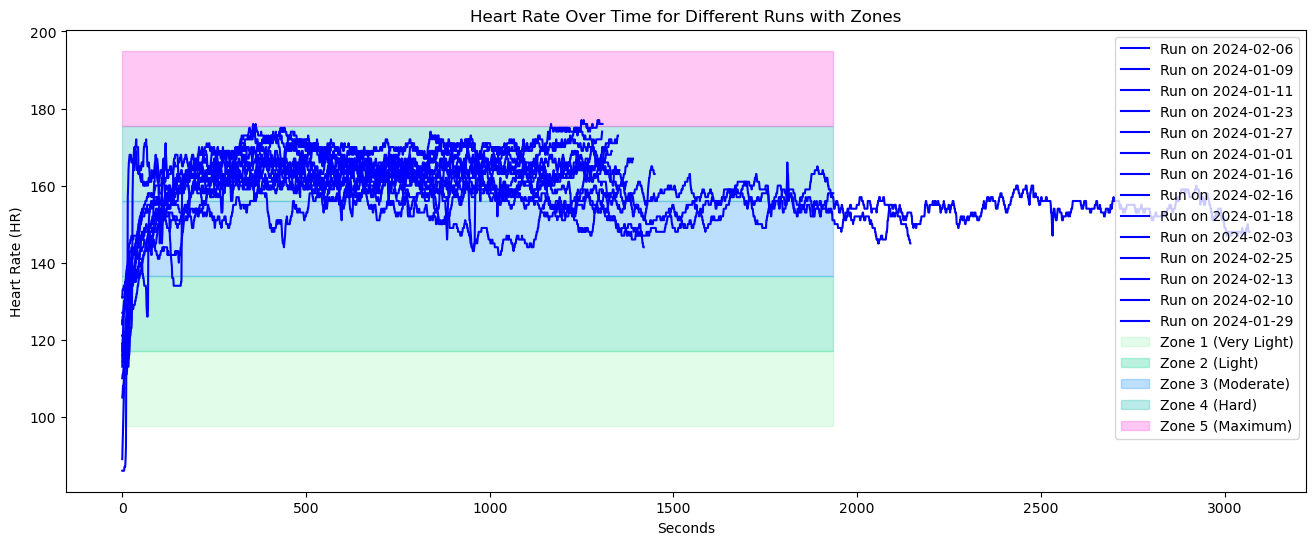

In [29]:
# Create a figure for the plot
plt.figure(figsize=(16, 6))

# Iterate through the unique dates to visualize the parameters of each run
for date in unique_runs:
    # Filter data for the current date
    data = filtered_data[filtered_data['Real_Time'].dt.date == date].copy()

    if data.empty:
        print(f"No data for {date}")
        continue

    # Sort by 'Real_Time'
    data = data.sort_values(by='Real_Time')

    # Calculate time difference from the first time of the day and extract total seconds
    time_difference = data['Real_Time'] - data['Real_Time'].min()
    data['seconds'] = time_difference.dt.total_seconds().astype(int)

    # Get HR and seconds for plotting
    hr = data['HR']
    seconds = data['seconds']

    # Plot HR against seconds
    plt.plot(seconds, hr, label=f'Run on {date}', color='blue')  # Use a uniform color for the line

# Shade the zones
for zone, (lower, upper) in zones.items():
    plt.fill_between([0, max(seconds)], lower, upper, color=np.random.rand(3,), alpha=0.3, label=zone)

# Add labels and title
plt.xlabel('Seconds')
plt.ylabel('Heart Rate (HR)')
plt.title('Heart Rate Over Time for Different Runs with Zones')

# Add a legend for the zones and runs
plt.legend(loc='upper right')

# Show the plot
plt.show()


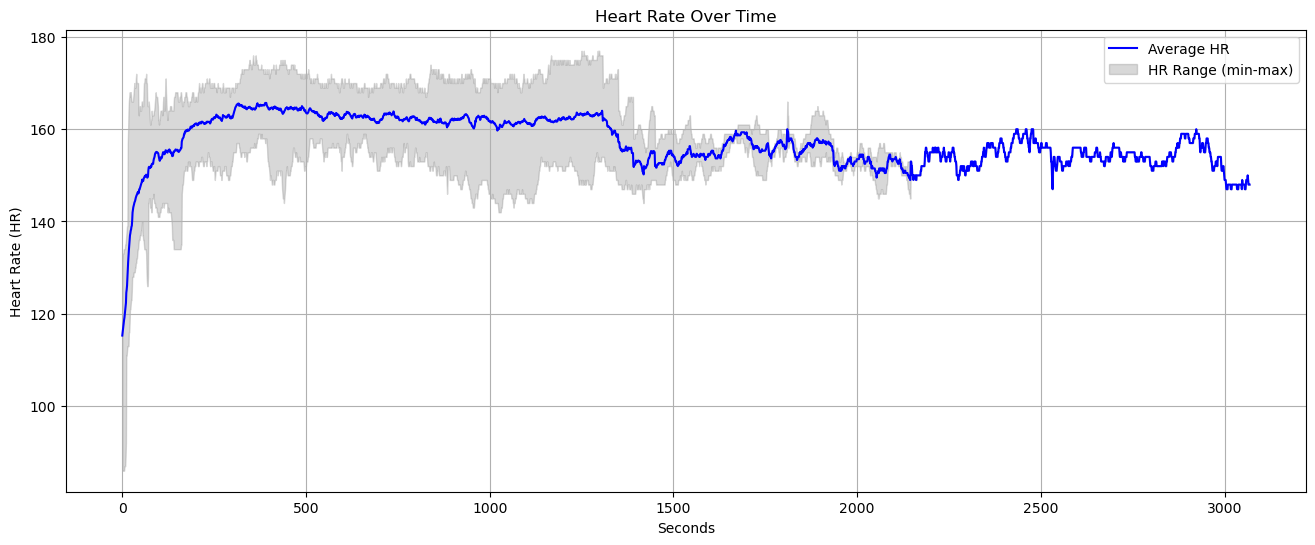

In [30]:
# Plot the average heart rate
plt.figure(figsize=(16, 6))
plt.plot(aggregated_data['seconds'], aggregated_data['mean_hr'], label='Average HR', color='blue')

# Fill between min and max HR to show the noise
plt.fill_between(aggregated_data['seconds'], aggregated_data['min_hr'], aggregated_data['max_hr'], color='gray', alpha=0.3, label='HR Range (min-max)')

# Add labels and title
plt.xlabel('Seconds')
plt.ylabel('Heart Rate (HR)')
plt.title('Heart Rate Over Time')

# Add a legend
plt.legend(loc='best')

# Show the plot with a grid
plt.grid(True)
plt.show()

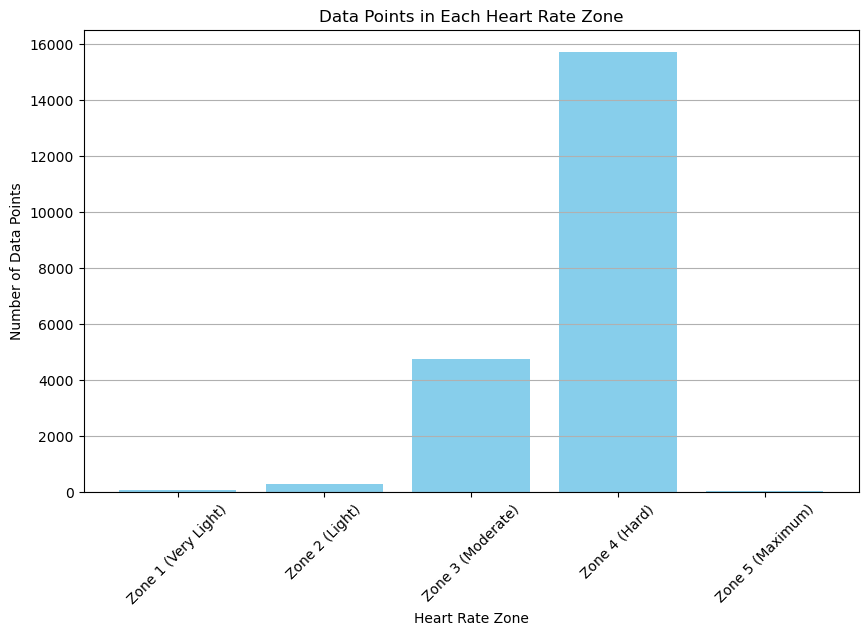

In [31]:
# Initialize a dictionary to hold the counts for each zone
zone_counts = {zone: 0 for zone in zones}

# Iterate through your normalized_data DataFrame to count the data points in each zone
for index, row in filtered_data.iterrows():
    hr = row['HR'] 
    for zone, (lower, upper) in zones.items():
        if lower <= hr < upper:
            zone_counts[zone] += 1
            break 

# Convert the zone counts to a DataFrame for easier plotting
zone_counts_df = pd.DataFrame(list(zone_counts.items()), columns=['Zone', 'Count'])

# Plotting the data
plt.figure(figsize=(10, 6))
plt.bar(zone_counts_df['Zone'], zone_counts_df['Count'], color='skyblue')
plt.xlabel('Heart Rate Zone')
plt.ylabel('Number of Data Points')
plt.title('Data Points in Each Heart Rate Zone')
plt.xticks(rotation=45)
plt.grid(axis='y')

# Show the plot
plt.show()

### Analyze Headers (Aggregated Data)

In [32]:
# Rename the Columns into Name without whitespaces
combined_headers_df.rename(columns={'Average heart rate (bpm)': 'Average_HR', 'Max speed (mi/h)': 'Max_Speed', 'Average speed (mi/h)': 'Average_Speed', 'Average pace (min/mi)': 'Average_Pace', 'Total distance (mi)': 'total_distance'}, inplace=True)

In [33]:
# Update time variable into readable units
combined_headers_df['Duration_in_minutes'] = combined_headers_df['Duration'].apply(convert_time_to_seconds)
combined_headers_df['Average_Pace_in_minutes'] = combined_headers_df['Average_Pace'].apply(convert_time_to_seconds)
combined_headers_df['Average_Speed_in_minutes'] = combined_headers_df['Average_Speed'].apply(convert_time_to_seconds)
combined_headers_df['Max_Speed_in_minutes'] = combined_headers_df['Max_Speed'].apply(convert_time_to_seconds)

In [34]:
# Convert both Date columns to datetime format
combined_headers_df['Date'] = pd.to_datetime(combined_headers_df['Date'], format='%d-%m-%Y')
total_count_of_rows_by_day['Date'] = pd.to_datetime(total_count_of_rows_by_day['Date'], format='%Y-%m-%d')

# Filter out rows in combined_headers_df where Date is in total_count_of_rows_by_day['Date']
filtered_headers_df = combined_headers_df[~combined_headers_df['Date'].isin(total_count_of_rows_by_day['Date'])]

# Optionally, print out the dates that were removed
for date in combined_headers_df['Date'].unique():
    if date in total_count_of_rows_by_day['Date'].values:
        print(f"Run dropped because of no heart rate: {date.strftime('%d-%m-%Y')}")

Run dropped because of no heart rate: 21-06-2024
Run dropped because of no heart rate: 03-07-2024
Run dropped because of no heart rate: 16-07-2024
Run dropped because of no heart rate: 24-07-2024
Run dropped because of no heart rate: 26-06-2024
Run dropped because of no heart rate: 27-07-2024
Run dropped because of no heart rate: 03-06-2024
Run dropped because of no heart rate: 09-06-2024
Run dropped because of no heart rate: 30-06-2024
Run dropped because of no heart rate: 20-07-2024


In [35]:
# Analyze Correlation
filtered_headers_df[['Duration_in_minutes', 'total_distance', 'Average_HR', 'Average_Speed_in_minutes', 'Max_Speed_in_minutes', 'Average_Pace_in_minutes']].corr()

,Duration_in_minutes,total_distance,Average_HR,Average_Speed_in_minutes,Max_Speed_in_minutes,Average_Pace_in_minutes
Duration_in_minutes,1.000000,0.994706,-0.284874,NaN,NaN,0.787849
total_distance,0.994706,1.000000,-0.224794,NaN,NaN,0.721100
Average_HR,-0.284874,-0.224794,1.000000,NaN,NaN,-0.574042
Average_Speed_in_minutes,NaN,NaN,NaN,NaN,NaN,NaN
Max_Speed_in_minutes,NaN,NaN,NaN,NaN,NaN,NaN
Average_Pace_in_minutes,0.787849,0.721100,-0.574042,NaN,NaN,1.000000


#### Negative Correlation between Average Heart Rate and Average Pace

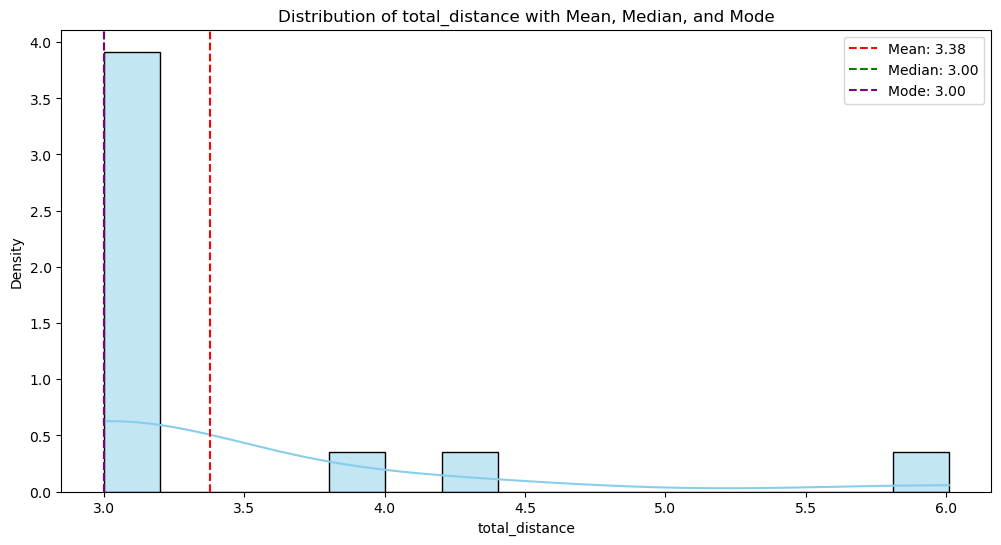

In [36]:
# Calculate the statistics
mean_value = filtered_headers_df['total_distance'].mean()
median_value = filtered_headers_df['total_distance'].median()
mode_value = filtered_headers_df['total_distance'].mode()[0]

# Set up the figure and bar plot
plt.figure(figsize=(12, 6))
sns.histplot(filtered_headers_df['total_distance'], kde=True, color='skyblue', stat='density', bins=15)

# Mark mean, median, and mode
plt.axvline(mean_value, color='red', linestyle='--', label=f'Mean: {mean_value:.2f}')
plt.axvline(median_value, color='green', linestyle='--', label=f'Median: {median_value:.2f}')
plt.axvline(mode_value, color='purple', linestyle='--', label=f'Mode: {mode_value:.2f}')

# Label and legend
plt.xlabel('total_distance')
plt.ylabel('Density')
plt.title('Distribution of total_distance with Mean, Median, and Mode')
plt.legend()

plt.show()

In [37]:
# Have three groups based on distance
try:
    under_three_miles = filtered_headers_df[filtered_headers_df['total_distance'] < 3.00]
    three_miles = filtered_headers_df[filtered_headers_df['total_distance'] == 3.00]
    over_three_miles = filtered_headers_df[filtered_headers_df['total_distance'] > 3.00]
    # Find counts of runs for each group
    under_three_count = under_three_miles.shape[0]
    three_count = three_miles.shape[0]
    over_three_count = over_three_miles.shape[0]

    print(f"There are {under_three_count} runs that are under 3 miles.")
    print(f"There are {three_count} runs that are exactly 3 miles.")
    print(f"There are {over_three_count} runs over 3 miles.")
except Exception as e:
    print(f"An unexpected error occured: {e}")

There are 0 runs that are under 3 miles.
There are 10 runs that are exactly 3 miles.
There are 4 runs over 3 miles.


## Modeling

In [38]:
# Create lagged features
for lag in range(1, 3): 
    filtered_data[f'HR_lag_{lag}'] = filtered_data['HR'].shift(lag)
    filtered_data[f'Pace_lag_{lag}'] = filtered_data['Pace'].shift(lag)
    filtered_data[f'Speed_lag_{lag}'] = filtered_data['Speed'].shift(lag)

In [39]:
# Label Features and labels
features = filtered_data[['seconds','Pace', 'Speed', 'HR_lag_1', 'HR_lag_2']]
labels = filtered_data['HR']

In [40]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size=0.3, random_state=42)

In [41]:
# Istantiate Model and fit it to the training dataset
model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

RandomForestRegressor(random_state=42)

In [42]:
# Predections on the testing dataset
predictions = model.predict(X_test)


In [43]:
# Calculate metrics
mae = mean_absolute_error(y_test, predictions)
rmse = root_mean_squared_error(y_test, predictions)
r_squared = r2_score(y_test, predictions)
pearson_corr = np.corrcoef(y_test, predictions)[0, 1]

print(f"Mean Absolute Error: {mae}")
print(f"Root Mean Squared Error: {rmse}")
print(f"R-squared: {r_squared}")
print(f"Pearson Correlation: {pearson_corr}")

Mean Absolute Error: 0.5107577008453448
Root Mean Squared Error: 0.9886638940092972
R-squared: 0.9852578844107265
Pearson Correlation: 0.9926055555578083


## Run the Model on an Unseen Run

In [44]:
# Specify the file path
unseen_run_file_path = 'test_data/David+_Diaz+_2024-02-28_17-51-31.CSV'
# Read the first row separately as it contains aggregated statistics
unseen_run_header = pd.read_csv(unseen_run_file_path, nrows=1)
# Grab the rest of the rows on the data
unseen_run_running = pd.read_csv(unseen_run_file_path, skiprows=[0, 1])

In [45]:
# Inspect Aggregated Header of the run
unseen_run_header

,Name,Sport,Date,Start time,Duration,Total distance (mi),Average heart rate (bpm),Average speed (mi/h),Max speed (mi/h),Average pace (min/mi),...,Descent (ft),Average power (W),Max power (W),Notes,Height (ft in),Weight (lbs),HR max,HR sit,VO2max,Unnamed: 27
0,David Diaz,RUNNING,28-02-2024,17:51:31,00:18:14,1.51,128,5.0,6.8,12:03,...,NaN,NaN,NaN,NaN,5 9,163.1,197,NaN,54,NaN


In [46]:
# Rename the Columns into Name without whitespaces
unseen_run_running.rename(columns={'HR (bpm)': 'HR', 'Speed (mi/h)': 'Speed', 'Pace (min/mi)': 'Original_Pace', 'Distances (ft)': 'distances'}, inplace=True)

In [47]:
# Create new Columns and utilize the function from above to convert into their respective units
unseen_run_running['Pace'] = unseen_run_running['Original_Pace'].apply(convert_time_to_seconds)

In [48]:
# Convert 'Time' column (hh:mm:ss format) to timedeltas
unseen_run_running['Time'] = pd.to_timedelta(unseen_run_running['Time'])

In [49]:
# Convert Time to total seconds
unseen_run_running['seconds'] = unseen_run_running['Time'].dt.total_seconds()

In [50]:
# Create lagged features
for lag in range(1, 3): 
    unseen_run_running[f'HR_lag_{lag}'] = unseen_run_running['HR'].shift(lag)
    unseen_run_running[f'Pace_lag_{lag}'] = unseen_run_running['Pace'].shift(lag)
    unseen_run_running[f'Speed_lag_{lag}'] = unseen_run_running['Speed'].shift(lag)

### This model is intended to utilize the parameters of the run and be able to predict windows of missing heart rate during a run. So the model is ran on the already existing run and able to learn the relationships between the parameters and heart rate. 

In [51]:
# Slice the 2 last minutes of the run 
cutoff_time = unseen_run_running['seconds'].max() - 120  # Two minutes in seconds
train_data = unseen_run_running[unseen_run_running['seconds'] <= cutoff_time]
predict_data = unseen_run_running[unseen_run_running['seconds'] > cutoff_time]

# Define features and labels for training
unseen_run_features = train_data[['seconds', 'Pace', 'Speed', 'HR_lag_1', 'HR_lag_2']]
unseen_run_labels = train_data['HR']

# Train the model on the run so far
model = RandomForestRegressor(random_state=42)
model.fit(unseen_run_features, unseen_run_labels)

# Prepare features for the prediction set (the last two minutes)
predict_features = predict_data[['seconds', 'Pace', 'Speed', 'HR_lag_1', 'HR_lag_2']]

# Make predictions for the last two minutes
predicted_hr = model.predict(predict_features)

# Add predictions to the predict_data 
predict_data['Predicted_HR'] = predicted_hr

/var/folders/m8/3d9l71wn6bs6v2c3m0gltnpr0000gn/T/ipykernel_64274/723132841.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  predict_data['Predicted_HR'] = predicted_hr


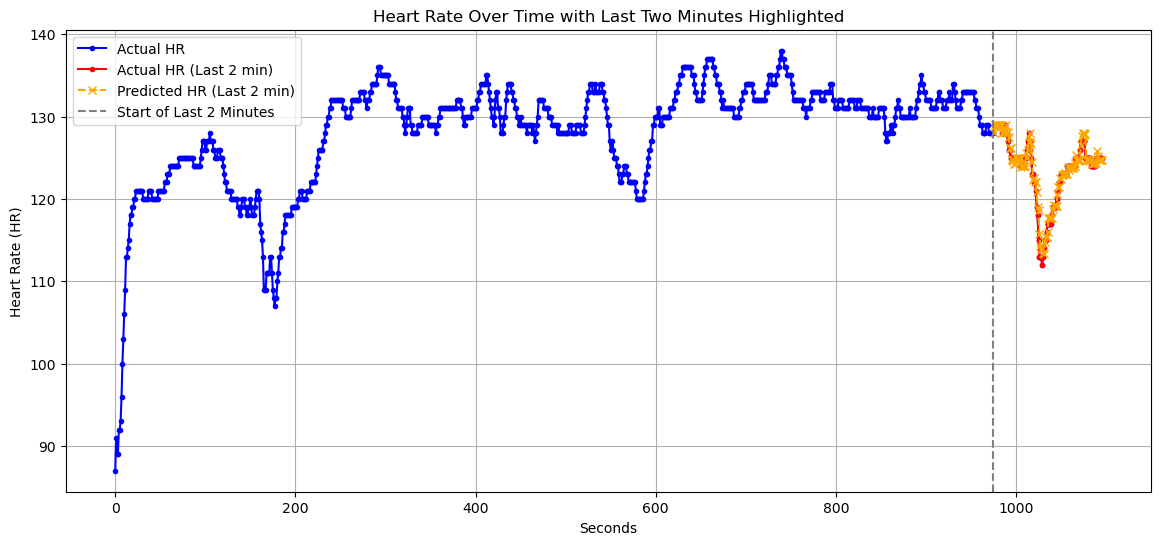

In [52]:
plt.figure(figsize=(14, 6))

# Plot actual heart rate for the entire run
plt.plot(unseen_run_running['seconds'], unseen_run_running['HR'], label='Actual HR', color='blue', linestyle='-', marker='o', markersize=3)

# Step 2: Highlight the last two minutes
# Get the last two minutes' actual heart rate
last_two_minutes_start = unseen_run_running['seconds'].max() - 120  # 120 seconds
highlighted_data = predict_data[predict_data['seconds'] > last_two_minutes_start]

# Plot actual heart rate for the last two minutes
plt.plot(highlighted_data['seconds'], highlighted_data['HR'], label='Actual HR (Last 2 min)', color='red', linestyle='-', marker='o', markersize=3)

# Plot predicted heart rate for the last two minutes
plt.plot(highlighted_data['seconds'], highlighted_data['Predicted_HR'], label='Predicted HR (Last 2 min)', color='orange', linestyle='--', marker='x')

# Adding labels and title
plt.xlabel('Seconds')
plt.ylabel('Heart Rate (HR)')
plt.title('Heart Rate Over Time with Last Two Minutes Highlighted')
plt.axvline(x=last_two_minutes_start, color='gray', linestyle='--', label='Start of Last 2 Minutes')  # Line indicating start of last 2 min
plt.legend()
plt.grid(True)

# Show the plot
plt.show()

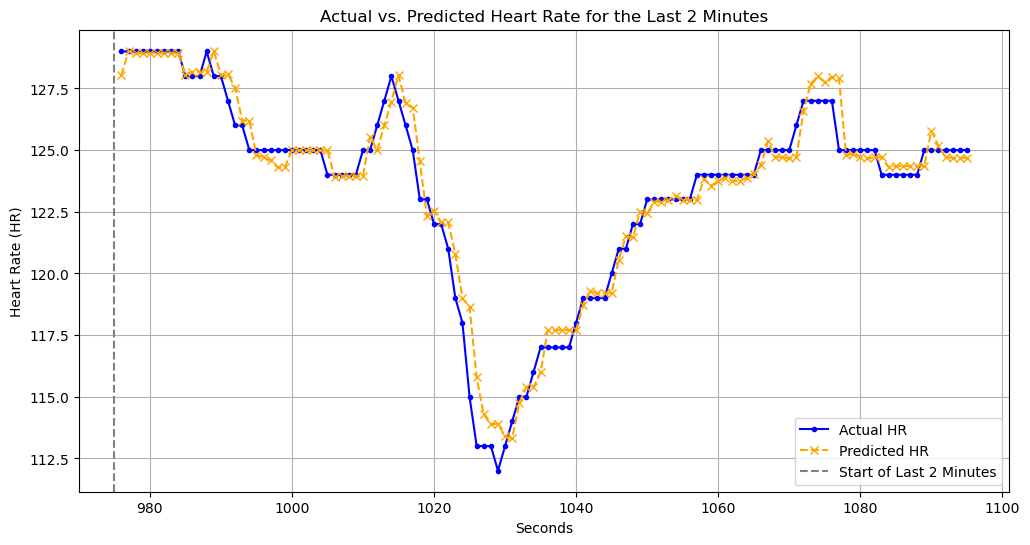

In [53]:
last_two_minutes_start = predict_data['seconds'].max() - 120  # Two minutes in seconds

#Filter the last two minutes of actual and predicted data
highlighted_actual = predict_data[predict_data['seconds'] > last_two_minutes_start]

plt.figure(figsize=(12, 6))

# Plot actual heart rate
plt.plot(highlighted_actual['seconds'], highlighted_actual['HR'], 
         label='Actual HR', color='blue', linestyle='-', marker='o', markersize=3)

# Plot predicted heart rate
plt.plot(highlighted_actual['seconds'], highlighted_actual['Predicted_HR'], 
         label='Predicted HR', color='orange', linestyle='--', marker='x')

# Adding labels and title
plt.xlabel('Seconds')
plt.ylabel('Heart Rate (HR)')
plt.title('Actual vs. Predicted Heart Rate for the Last 2 Minutes')
plt.axvline(x=last_two_minutes_start, color='gray', linestyle='--', 
            label='Start of Last 2 Minutes')  # Line indicating start of last 2 min
plt.legend()
plt.grid(True)

# Show the plot
plt.show()

In [54]:
# Analyze actual and predicted Heart Rate Values
actual = predict_data['HR']
predicted = predict_data['Predicted_HR']
# Calculate MAE
mae = mean_absolute_error(actual, predicted)
# Calculate RMSE
rmse = root_mean_squared_error(actual, predicted)
# Calculate R-squared
r2 = r2_score(actual, predicted)
# Pearson Correlation
correlation = np.corrcoef(actual, predicted)[0, 1]

print(f'Mean Absolute Error: {mae}')
print(f'Root Mean Squared Error: {rmse}')
print(f'R-squared: {r2}')
print(f'Pearson Correlation: {correlation}')

Mean Absolute Error: 0.5591666666666668
Root Mean Squared Error: 0.816068828796526
R-squared: 0.9596774852731561
Pearson Correlation: 0.9806334816967822
